In [1]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt
import astropy
from astropy.io import fits, ascii
from astropy.table import Table, Column
import scipy
import pickle
from scipy.stats import poisson
from scipy.misc import factorial
import pymc3 as pm
from theano.compile.ops import as_op
import theano.tensor as T
from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel, Tophat2DKernel
from astropy.modeling.models import Gaussian2D
from astropy.convolution import CustomKernel

Populating the interactive namespace from numpy and matplotlib


(21, 21)


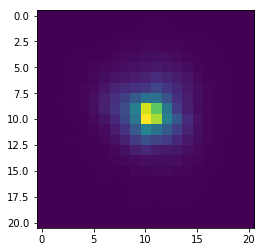

In [2]:
hdul = fits.open('/data/L3/rafael/dataplay/threads/sherpa/2dpsf/psf_f1_norm_0.25pix.fits')
psf_data = hdul[0].data[118:139,117:138]
plt.imshow(psf_data)
print (np.shape(psf_data))

(21, 21)
73.5 84.5


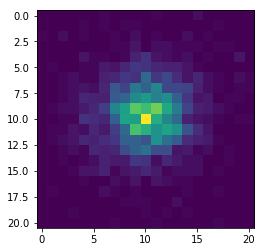

In [3]:
hdul = fits.open('/data/L3/rafael/dataplay/threads/sherpa/2dpsf/center_box_0.25pix.fits')
img_data = hdul[0].data[66:87,78:99]
plt.imshow(img_data)
print (np.shape(img_data))
print(147./2,169./2)

In [4]:
# Simulate the data
np.random.seed(2)
x0low, x0high = 0,21
x1low, x1high = 0,21
dx = 1
x1, x0 = np.mgrid[x1low:x1high:dx, x0low:x0high:dx]

In [5]:
# Convert to 1D arrays
#shape = x0.shape
#x0, x1 = x0.flatten(), x1.flatten()
#shape1 = x0.shape
#print (shape)

# Convert to 1D arrays
shape = x0.shape
x0, x1 = x0.flatten(), x1.flatten()
print (shape)

(21, 21)


In [8]:
from sherpa.astro.models import Beta2D
source_model = pm.Model()

@as_op(itypes=[T.dscalar, T.dscalar, T.dscalar, T.dscalar, T.dscalar], otypes=[T.dmatrix])
def counts_func(r0, xpos, ypos, ampl, alpha):
    truth = Beta2D()
    truth.xpos, truth.ypos = xpos, ypos
    truth.r0, truth.alpha = r0, alpha
    truth.ampl = ampl
    
    kernel = CustomKernel(psf_data)
    astropy_conv = convolve_fft(truth(x0, x1).reshape(shape), kernel, normalize_kernel=True)
    #truth1 = Beta2D()
    #truth1.xpos, truth1.ypos = xpos1, ypos1
    #truth1.r0, truth1.alpha = r01, alpha1
    #truth1.ampl = ampl1
    return astropy_conv
    
 
with source_model:
    
    # priors
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0, upper=5.0)
    r0 = BoundedNormal('r0', mu=4.0, sd=2.0)
    xpos = pm.Normal('xpos', mu=10.0, sd=3.0)
    ypos = pm.Normal('ypos', mu=10.0, sd=3.0)
    ampl = pm.Normal('ampl', mu=100.0, sd=30.0)
    alpha = pm.Uniform('alpha', lower=0.0, upper=10.0)
    #r01 = BoundedNormal('r01', mu=2.0, sd=5.0)
    #xpos1 = pm.Normal('xpos1', mu=3550.0, sd=100.0)
    #ypos1 = pm.Normal('ypos1', mu=4550.0, sd=100.0)
    #ampl1 = pm.Uniform('ampl1', lower=0.0, upper=5000.0)
    #alpha1 = BoundedNormal('alpha1', mu=2.0, sd=5.0)
                       
    counts = counts_func(r0, xpos, ypos, ampl, alpha)
    #counts = np.empty_like(msim)
    
    def log_like(img):
        logpm = np.array(counts - img*np.log(counts))
        return -2.0*np.sum(logpm)
    
    likelihood = pm.DensityDist("likelihood", log_like, observed=img_data)  
    
    #likelihood = pm.DensityDist("likelihood", log_like, observed=msim)                   
    #likelihood = pm.Poisson('likelihood', mu=counts, observed=msim)

In [9]:
from scipy import optimize

with source_model:
    map_estimate = pm.find_MAP(fmin=scipy.optimize.fmin_powell, model=source_model)
    step = pm.Slice()
    trace = pm.sample(10000,step,map_estimate)

/export/jgalarza/software/anaconda/lib/python3.6/site-packages/pymc3/tuning/starting.py:91: UserWarning: In future versions, set the optimization algorithm with a string. For example, use `method="L-BFGS-B"` instead of `fmin=sp.optimize.fmin_l_bfgs_b"`.
  warnings.warn('In future versions, set the optimization algorithm with a string. '
logp = 5,114.6:   6%|▌         | 287/5000 [00:00<00:10, 437.14it/s]


Optimization terminated successfully.
         Current function value: -5115.015761
         Iterations: 5
         Function evaluations: 287


100%|██████████| 10500/10500 [09:08<00:00, 19.14it/s]


In [17]:
map_estimate = pm.find_MAP(fmin=scipy.optimize.fmin_powell, model=source_model)

/export/jgalarza/software/anaconda/lib/python3.6/site-packages/pymc3/tuning/starting.py:91: UserWarning: In future versions, set the optimization algorithm with a string. For example, use `method="L-BFGS-B"` instead of `fmin=sp.optimize.fmin_l_bfgs_b"`.
  warnings.warn('In future versions, set the optimization algorithm with a string. '
logp = 5,114.6:   6%|▌         | 280/5000 [00:00<00:11, 428.17it/s]

Optimization terminated successfully.
         Current function value: -5115.015761
         Iterations: 5
         Function evaluations: 287


In [18]:
map_estimate

{'alpha': array(2.43279595996488),
 'alpha_interval__': array(-1.1347824550771415),
 'ampl': array(185.97554456126252),
 'r0': array(2.059071650856813),
 'r0_interval__': array(-0.3564700702198356),
 'xpos': array(9.613644015958277),
 'ypos': array(10.229705703605537)}

logp = 5,114.6:   6%|▌         | 287/5000 [00:20<00:11, 428.17it/s]

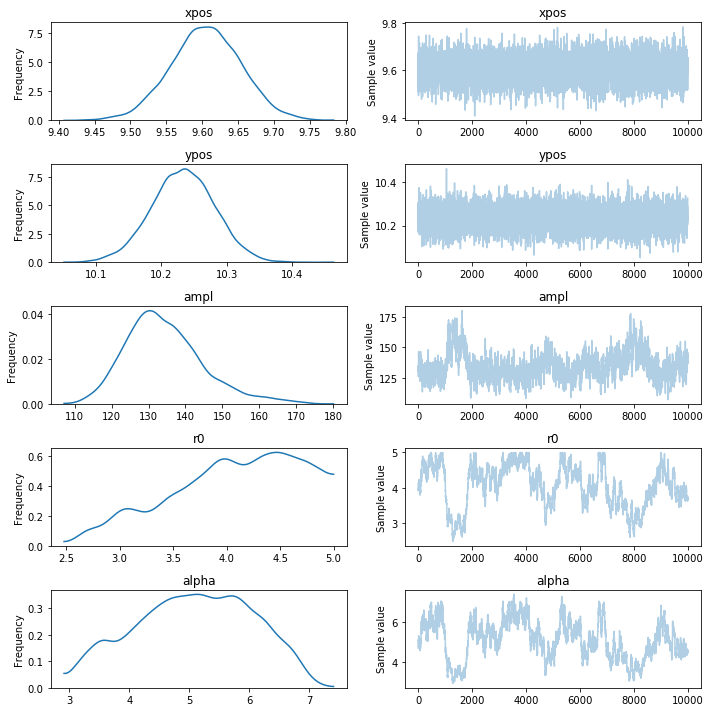

In [10]:
fig, axs = plt.subplots(5, 2,figsize=(10,10)) # 3 RVs
_ = pm.traceplot(trace, ax=axs)
fig.savefig('traces4.pdf')

In [24]:
truth = Beta2D()
#truth.xpos, truth.ypos = 9.61,10.23
#truth.r0, truth.alpha = 4.4, 5.2
#truth.ampl = 130
truth.xpos, truth.ypos = 9.61,10.23
truth.r0, truth.alpha = 2.06, 2.43
truth.ampl = 185.97
mexp = truth(x0, x1).reshape(shape)

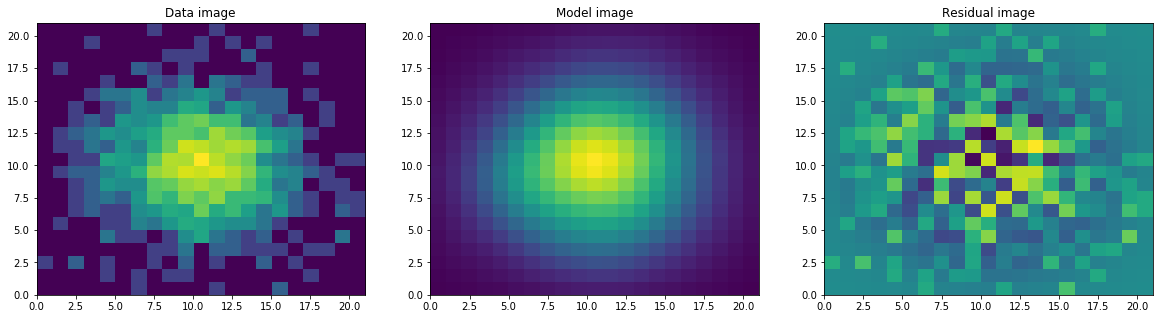

In [25]:
kernel = CustomKernel(psf_data)
conv_model = convolve_fft(mexp, kernel, normalize_kernel=True)

# Plot
plt.subplots(1,3,figsize=(20,5))
plt.subplot(1,3,1)
plt.imshow(np.arcsinh(img_data.reshape(shape)), origin='lower', cmap='viridis', 
           extent=(x0low, x0high, x1low, x1high), interpolation='nearest', aspect='auto')
plt.title('Data image')
plt.subplot(1,3,2)
plt.imshow(np.arcsinh(conv_model), origin='lower', cmap='viridis', 
           extent=(x0low, x0high, x1low, x1high), interpolation='nearest', aspect='auto')
plt.title('Model image')
plt.subplot(1,3,3)
plt.imshow(np.arcsinh(img_data.reshape(shape)-conv_model), origin='lower', cmap='viridis', 
           extent=(x0low, x0high, x1low, x1high), interpolation='nearest', aspect='auto')
plt.title('Residual image')
plt.savefig('PG1634_m3.png')